# 付録A1: 多元的無知のネットワークモデル

## 学習目標
- 多元的無知（Pluralistic Ignorance）の概念を理解する
- NetworkXを使ってエージェントベースモデルを構築する
- ネットワーク構造が社会現象に与える影響をシミュレーションで検証する
- 介入効果の分析方法を学ぶ

## 難易度: 上級

---
## A1.1 多元的無知とは？

**多元的無知（Pluralistic Ignorance）** とは、集団内の多くの人が私的には同じ意見を持っているにもかかわらず、互いに他者は自分と異なる意見を持っていると誤って信じている状態を指します。

### 具体例
- 授業中、多くの学生が「わからない」と思っているのに、誰も質問しない
- 職場で多くの人が制度に反対なのに、皆が賛成しているように見える
- 「本心では反対だが、周りは賛成に見えるので合わせる」という連鎖

### モデル化の要点
このチュートリアルでは、以下の要素をモデル化します：

| 要素 | 説明 |
|------|------|
| 私的信念 $b_i$ | エージェントの本心（0=反対、1=賛成） |
| 公的発言 $s_i$ | 表明する意見（0=反対、1=賛成、None=沈黙） |
| 観測規範 $p_i$ | 周囲の発言から推測する「世間の意見」 |
| しきい値 $\tau_i$ | 賛成と発言するために必要な観測賛成比率 |

---
## A1.2 環境のセットアップ

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

print(f"NetworkX version: {nx.__version__}")
print(f"NumPy version: {np.__version__}")

NetworkX version: 3.6.1
NumPy version: 2.3.5


---
## A1.3 ステップ1: ネットワーク構造の生成

まず、エージェント間の関係を表すネットワークを生成します。ネットワーク構造によって情報の伝播パターンが変わるため、複数のモデルを試してみましょう。

### ネットワークモデルの選択肢

| モデル | 特徴 | 現実の例 |
|--------|------|----------|
| Erdős-Rényi (ER) | ランダム接続、均一な次数分布 | 理論的ベースライン |
| Watts-Strogatz (WS) | 高クラスタリング、短い平均経路長 | 友人ネットワーク |
| Barabási-Albert (BA) | スケールフリー、ハブの存在 | SNS、引用ネットワーク |

In [2]:
def create_network(n, graph_type, seed=42):
    """
    指定されたタイプのネットワークを生成する
    
    Parameters:
    -----------
    n : int
        ノード数
    graph_type : str
        "ER", "WS", "BA" のいずれか
    seed : int
        乱数シード
    
    Returns:
    --------
    G : networkx.Graph
        生成されたグラフ（連結成分のみ）
    """
    if graph_type.upper() == "ER":
        # Erdős-Rényi: 各エッジが確率pで存在
        G = nx.erdos_renyi_graph(n=n, p=0.02, seed=seed)
    elif graph_type.upper() == "WS":
        # Watts-Strogatz: リングに近接接続 + ランダム再配線
        G = nx.watts_strogatz_graph(n=n, k=10, p=0.05, seed=seed)
    elif graph_type.upper() == "BA":
        # Barabási-Albert: 優先的選択による成長
        G = nx.barabasi_albert_graph(n=n, m=3, seed=seed)
    else:
        raise ValueError("graph_type must be one of: ER, WS, BA")
    
    # 連結成分のみを取り出す（非連結の場合）
    if not nx.is_connected(G):
        giant = max(nx.connected_components(G), key=len)
        G = G.subgraph(giant).copy()
    
    return G

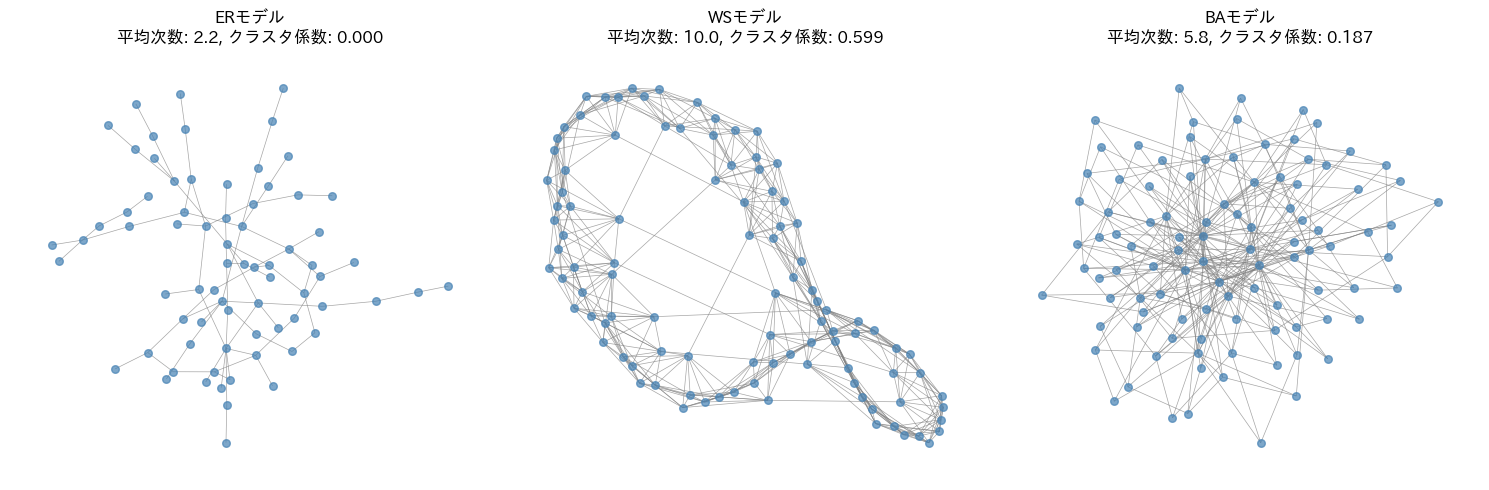

In [3]:
# 各ネットワークタイプを生成して比較
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, gtype in zip(axes, ["ER", "WS", "BA"]):
    G = create_network(100, gtype, seed=42)
    
    # ネットワーク特性を計算
    avg_degree = np.mean([d for n, d in G.degree()])
    clustering = nx.average_clustering(G)
    
    # 可視化
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, ax=ax, node_size=30, node_color='steelblue',
            edge_color='gray', alpha=0.7, width=0.5)
    ax.set_title(f"{gtype}モデル\n平均次数: {avg_degree:.1f}, クラスタ係数: {clustering:.3f}")

plt.tight_layout()
plt.show()

---
## A1.4 ステップ2: エージェントの属性設定

各ノード（エージェント）に以下の属性を割り当てます：

1. **私的信念 $b_i$**: 本心での賛成(1)または反対(0)
2. **タイプ**: 同調者(conformist)または逆張り者(contrarian)
3. **しきい値 $\tau_i$**: 賛成と発言するために必要な観測賛成比率

In [4]:
def initialize_agents(G, private_yes_rate=0.25, contrarian_rate=0.05,
                      tau_mean=0.60, tau_sd=0.08, seed=42):
    """
    エージェントの属性を初期化する
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    private_yes_rate : float
        私的に賛成のエージェントの割合
    contrarian_rate : float
        逆張り者の割合
    tau_mean : float
        しきい値の平均
    tau_sd : float
        しきい値の標準偏差
    
    Returns:
    --------
    dict: 各属性の辞書
    """
    rng = random.Random(seed)
    np_rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    
    # 私的信念: 実際には少数派が賛成
    b = {i: 1 if rng.random() < private_yes_rate else 0 for i in nodes}
    
    # 逆張り者フラグ
    is_contrarian = {i: (rng.random() < contrarian_rate) for i in nodes}
    
    # しきい値（正規分布）
    tau = {}
    for i in nodes:
        x = np_rng.normal(tau_mean, tau_sd)
        tau[i] = float(np.clip(x, 0.05, 0.95))
    
    # 初期の公的発言（やや賛成寄りに見せる）
    s = {i: (1 if rng.random() < 0.55 else 0) for i in nodes}
    
    return {
        'b': b,                    # 私的信念
        'is_contrarian': is_contrarian,  # 逆張りフラグ
        'tau': tau,                # しきい値
        's': s                     # 公的発言
    }

In [5]:
# サンプルネットワークでエージェントを初期化
G = create_network(500, "BA", seed=42)
agents = initialize_agents(G, private_yes_rate=0.25, seed=42)

# 統計を確認
nodes = list(G.nodes())
private_yes = sum(agents['b'].values()) / len(nodes)
public_yes = sum(agents['s'].values()) / len(nodes)
contrarians = sum(agents['is_contrarian'].values()) / len(nodes)

print(f"ノード数: {len(nodes)}")
print(f"私的信念（賛成率）: {private_yes:.1%}")
print(f"初期の公的発言（賛成率）: {public_yes:.1%}")
print(f"逆張り者の割合: {contrarians:.1%}")
print(f"しきい値の平均: {np.mean(list(agents['tau'].values())):.3f}")

ノード数: 500
私的信念（賛成率）: 26.0%
初期の公的発言（賛成率）: 56.6%
逆張り者の割合: 4.0%
しきい値の平均: 0.599


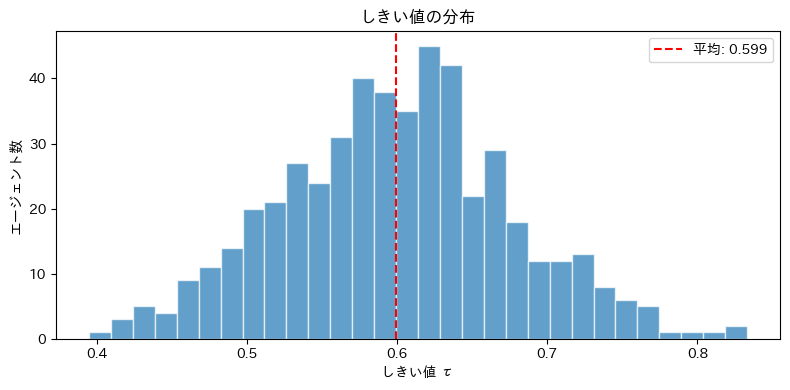

In [6]:
# しきい値の分布を可視化
plt.figure(figsize=(8, 4))
plt.hist(list(agents['tau'].values()), bins=30, edgecolor='white', alpha=0.7)
plt.axvline(np.mean(list(agents['tau'].values())), color='red', 
            linestyle='--', label=f'平均: {np.mean(list(agents["tau"].values())):.3f}')
plt.xlabel('しきい値 τ')
plt.ylabel('エージェント数')
plt.title('しきい値の分布')
plt.legend()
plt.tight_layout()
plt.show()

---
## A1.5 ステップ3: 観測規範の計算

各エージェントは、以下の2つの情報源から「世間の意見」を推測します：

1. **ローカル情報**: 隣接ノードの発言
2. **メディア情報**: 全体の発言平均（バイアス付き）

観測規範 $p_i$ は以下で計算されます：

$$p_i = (1 - w) \cdot \text{local}_i + w \cdot \text{media}$$

ここで $w$ はメディアの影響度です。

In [7]:
def compute_observed_norm(G, i, s, global_signal, media_weight=0.15):
    """
    エージェントiが観測する賛成比率を計算
    
    Parameters:
    -----------
    G : networkx.Graph
        ネットワーク
    i : node
        対象エージェント
    s : dict
        現在の公的発言状態
    global_signal : float
        メディアからのグローバルシグナル
    media_weight : float
        メディアの影響度 (0〜1)
    
    Returns:
    --------
    float: 観測される賛成比率
    """
    # ローカル情報: 隣接ノードの発言
    neighbors = list(G.neighbors(i))
    if len(neighbors) == 0:
        local = 0.5
    else:
        # 沈黙していないノードのみ考慮
        visible_vals = [s[j] for j in neighbors if s[j] is not None]
        if len(visible_vals) == 0:
            local = 0.5  # 近傍が全員沈黙なら中立
        else:
            local = float(np.mean(visible_vals))
    
    # ローカルとメディアを混合
    return (1 - media_weight) * local + media_weight * global_signal

In [8]:
# 観測規範の例
sample_node = list(G.nodes())[0]
global_signal = 0.6  # メディアは60%が賛成と報道

p_i = compute_observed_norm(G, sample_node, agents['s'], global_signal, media_weight=0.15)

neighbors = list(G.neighbors(sample_node))
local_yes = np.mean([agents['s'][j] for j in neighbors])

print(f"サンプルノード {sample_node}:")
print(f"  隣接ノード数: {len(neighbors)}")
print(f"  ローカル賛成率: {local_yes:.1%}")
print(f"  メディアシグナル: {global_signal:.1%}")
print(f"  観測規範 p_i: {p_i:.1%}")

サンプルノード 0:
  隣接ノード数: 38
  ローカル賛成率: 63.2%
  メディアシグナル: 60.0%
  観測規範 p_i: 62.7%


---
## A1.6 ステップ4: 沈黙と発言の決定

エージェントは以下のルールで発言/沈黙を決定します：

### 沈黙確率
本心と観測規範のズレが大きいほど沈黙しやすい：

$$P(\text{沈黙}) = \text{base} + \text{sensitivity} \times |b_i - p_i|$$

### 発言内容の決定
- **同調者**: 観測規範 $p_i \geq \tau_i$ なら「賛成」と発言
- **逆張り者**: 同調者と逆の発言

In [9]:
def decide_statement(G, i, s, b, tau, is_contrarian, global_signal,
                     media_weight=0.15, silence_base=0.05, 
                     silence_sensitivity=1.2, rng=None):
    """
    エージェントiの発言を決定する
    
    Returns:
    --------
    int or None: 1=賛成, 0=反対, None=沈黙
    """
    if rng is None:
        rng = random.Random()
    
    # 観測規範を計算
    p_i = compute_observed_norm(G, i, s, global_signal, media_weight)
    
    # 本心と規範のズレを計算
    # 本心1(賛成)なら、規範が低いほどズレが大きい
    # 本心0(反対)なら、規範が高いほどズレが大きい
    if b[i] == 1:
        mismatch_level = 1 - p_i
    else:
        mismatch_level = p_i
    
    # 沈黙確率を計算
    p_silence = silence_base + silence_sensitivity * mismatch_level
    p_silence = float(np.clip(p_silence, 0.0, 0.95))
    
    # 沈黙するかどうか
    if rng.random() < p_silence:
        return None  # 沈黙
    
    # しきい値モデルで発言を決定
    says_yes = (p_i >= tau[i])
    
    # 逆張り者は反転
    if is_contrarian[i]:
        says_yes = not says_yes
    
    return 1 if says_yes else 0

In [10]:
# 発言決定のデモ
rng = random.Random(42)

# いくつかのエージェントの発言を確認
print("発言決定のデモ:")
print("-" * 60)

for i in list(G.nodes())[:5]:
    p_i = compute_observed_norm(G, i, agents['s'], 0.6, media_weight=0.15)
    statement = decide_statement(
        G, i, agents['s'], agents['b'], agents['tau'], 
        agents['is_contrarian'], 0.6, rng=rng
    )
    
    print(f"ノード {i:3d}: 本心={agents['b'][i]}, τ={agents['tau'][i]:.2f}, "
          f"p_i={p_i:.2f}, 発言={statement}")

発言決定のデモ:
------------------------------------------------------------
ノード   0: 本心=0, τ=0.62, p_i=0.63, 発言=None
ノード   1: 本心=1, τ=0.52, p_i=0.59, 発言=None
ノード   2: 本心=0, τ=0.66, p_i=0.94, 発言=None
ノード   3: 本心=1, τ=0.68, p_i=0.56, 発言=None
ノード   4: 本心=0, τ=0.44, p_i=0.58, 発言=None


---
## A1.7 ステップ5: シミュレーションの実行

ここまでの要素を統合して、完全なシミュレーションを実行します。

In [11]:
def simulate_pluralistic_ignorance(
    n=500,
    graph_type="BA",
    seed=0,
    private_yes_rate=0.25,
    contrarian_rate=0.05,
    tau_mean=0.60,
    tau_sd=0.08,
    silence_base=0.05,
    silence_sensitivity=1.2,
    media_weight=0.15,
    media_bias=0.10,
    media_noise=0.03,
    synchronous=True,
    T=120,
    intervention_t=None,
    transparency=0.40,
):
    """
    多元的無知のシミュレーションを実行
    
    Parameters:
    -----------
    n : int
        ノード数
    graph_type : str
        ネットワークタイプ ("ER", "WS", "BA")
    seed : int
        乱数シード
    private_yes_rate : float
        私的に賛成の割合
    contrarian_rate : float
        逆張り者の割合
    tau_mean, tau_sd : float
        しきい値の平均と標準偏差
    silence_base, silence_sensitivity : float
        沈黙モデルのパラメータ
    media_weight : float
        メディアの影響度
    media_bias : float
        メディアの賛成側バイアス
    media_noise : float
        メディアシグナルのノイズ
    synchronous : bool
        同期更新かどうか
    T : int
        シミュレーション期間
    intervention_t : int or None
        介入開始時点（Noneなら介入なし）
    transparency : float
        介入時の真の私的平均の開示度
    
    Returns:
    --------
    dict: シミュレーション結果
    """
    rng = random.Random(seed)
    np_rng = np.random.default_rng(seed)
    
    # ネットワーク生成
    G = create_network(n, graph_type, seed)
    nodes = list(G.nodes())
    N = len(nodes)
    
    # エージェント初期化
    b = {i: 1 if rng.random() < private_yes_rate else 0 for i in nodes}
    is_contrarian = {i: (rng.random() < contrarian_rate) for i in nodes}
    tau = {}
    for i in nodes:
        x = np_rng.normal(tau_mean, tau_sd)
        tau[i] = float(np.clip(x, 0.05, 0.95))
    s = {i: (1 if rng.random() < 0.55 else 0) for i in nodes}
    
    # 記録用
    hist_private = []
    hist_public = []
    hist_mismatch = []
    hist_silence = []
    
    private_mean = float(np.mean([b[i] for i in nodes]))
    
    for t in range(T):
        # メディアシグナルの計算
        visible = [s[i] for i in nodes if s[i] is not None]
        public_mean = float(np.mean(visible)) if len(visible) else 0.5
        global_signal = public_mean + media_bias + float(np_rng.normal(0, media_noise))
        global_signal = float(np.clip(global_signal, 0.0, 1.0))
        
        # 介入：真の私的平均を部分的に開示
        if intervention_t is not None and t >= intervention_t:
            global_signal = (1 - transparency) * global_signal + transparency * private_mean
        
        # 全エージェントの発言を更新
        if synchronous:
            s_next = {}
            for i in nodes:
                s_next[i] = decide_statement(
                    G, i, s, b, tau, is_contrarian, global_signal,
                    media_weight, silence_base, silence_sensitivity, rng
                )
            s = s_next
        else:
            order = nodes[:]
            rng.shuffle(order)
            for i in order:
                s[i] = decide_statement(
                    G, i, s, b, tau, is_contrarian, global_signal,
                    media_weight, silence_base, silence_sensitivity, rng
                )
        
        # ログ集計
        hist_private.append(private_mean)
        
        visible = [s[i] for i in nodes if s[i] is not None]
        pub = float(np.mean(visible)) if len(visible) else 0.5
        hist_public.append(pub)
        
        silence_rate = 1.0 - (len(visible) / N)
        hist_silence.append(silence_rate)
        
        spoken = [i for i in nodes if s[i] is not None]
        if len(spoken) == 0:
            hist_mismatch.append(0.0)
        else:
            mm = float(np.mean([1 if s[i] != b[i] else 0 for i in spoken]))
            hist_mismatch.append(mm)
    
    return {
        "G": G,
        "b": b,
        "s": s,
        "is_contrarian": is_contrarian,
        "tau": tau,
        "hist_private": np.array(hist_private),
        "hist_public": np.array(hist_public),
        "hist_mismatch": np.array(hist_mismatch),
        "hist_silence": np.array(hist_silence),
        "meta": {
            "graph_type": graph_type,
            "private_yes_rate": private_yes_rate,
            "contrarian_rate": contrarian_rate,
            "tau_mean": tau_mean,
            "silence_base": silence_base,
            "silence_sensitivity": silence_sensitivity,
            "media_weight": media_weight,
            "media_bias": media_bias,
            "intervention_t": intervention_t,
            "transparency": transparency,
        }
    }

---
## A1.8 ステップ6: 結果の可視化

In [12]:
def plot_simulation_results(res):
    """
    シミュレーション結果を可視化
    """
    hp = res["hist_private"]
    hpub = res["hist_public"]
    hmm = res["hist_mismatch"]
    hsil = res["hist_silence"]
    meta = res["meta"]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左: 私的 vs 公的
    ax1 = axes[0]
    ax1.plot(hp, label="私的信念（賛成割合）", linewidth=2, color='blue')
    ax1.plot(hpub, label="公的発言（賛成割合）", linewidth=2, color='orange')
    ax1.fill_between(range(len(hp)), hp, hpub, alpha=0.3, color='red', 
                     label='ギャップ（多元的無知）')
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("時点 t")
    ax1.set_ylabel("割合")
    title = f"私的信念 vs 公的発言（{meta['graph_type']}）"
    if meta["intervention_t"] is not None:
        title += f"\n介入 t={meta['intervention_t']}"
        ax1.axvline(meta["intervention_t"], linestyle="--", color='green', 
                   label='介入開始')
    ax1.set_title(title)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 右: 不一致率と沈黙率
    ax2 = axes[1]
    ax2.plot(hmm, label="不一致率（本心≠発言）", linewidth=2, color='red')
    ax2.plot(hsil, label="沈黙率", linewidth=2, color='gray')
    ax2.set_ylim(0, 1)
    ax2.set_xlabel("時点 t")
    ax2.set_ylabel("割合")
    ax2.set_title("ズレ（多元的無知）と沈黙")
    if meta["intervention_t"] is not None:
        ax2.axvline(meta["intervention_t"], linestyle="--", color='green',
                   label='介入開始')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

シミュレーション1: 介入なし



私的信念（賛成割合）: 23.8%
最終の公的発言（賛成割合）: 2.4%
平均沈黙率（後半10期）: 31.4%
平均不一致率（後半10期）: 4.3%


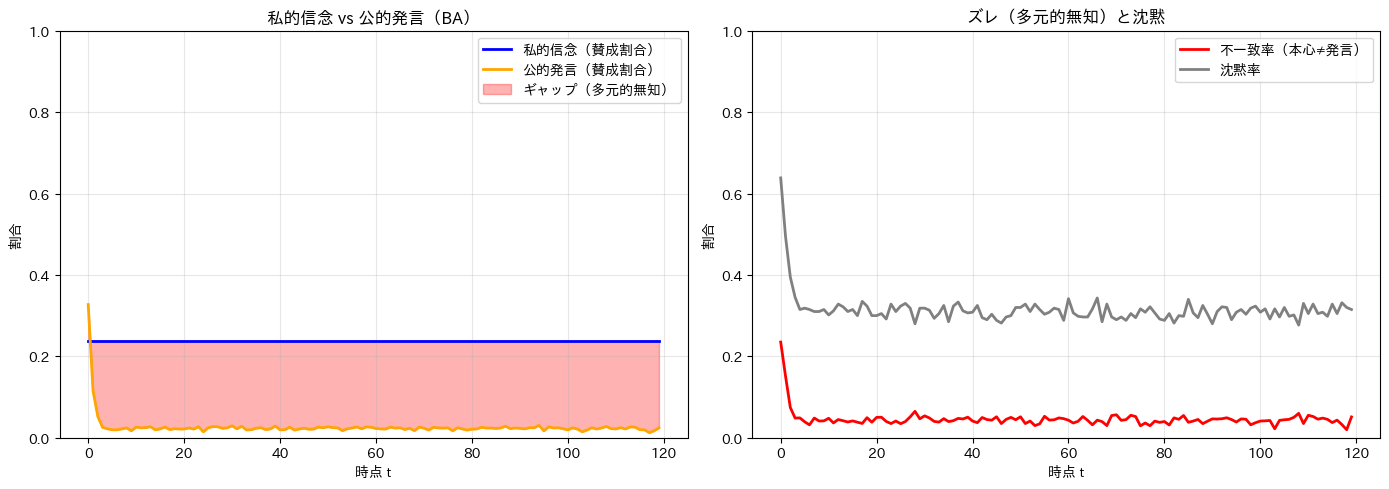

In [13]:
# 介入なしのシミュレーション
print("=" * 60)
print("シミュレーション1: 介入なし")
print("=" * 60)

res1 = simulate_pluralistic_ignorance(
    n=600,
    graph_type="BA",
    seed=1,
    private_yes_rate=0.25,   # 本心では賛成が少数（25%）
    tau_mean=0.62,
    silence_base=0.06,
    silence_sensitivity=1.1,
    media_weight=0.18,
    media_bias=0.10,         # メディアが賛成側に寄せる
    contrarian_rate=0.03,
    intervention_t=None,
    T=120,
)

# 結果サマリー
print(f"\n私的信念（賛成割合）: {np.mean(list(res1['b'].values())):.1%}")
visible = [v for v in res1['s'].values() if v is not None]
print(f"最終の公的発言（賛成割合）: {np.mean(visible):.1%}")
print(f"平均沈黙率（後半10期）: {np.mean(res1['hist_silence'][-10:]):.1%}")
print(f"平均不一致率（後半10期）: {np.mean(res1['hist_mismatch'][-10:]):.1%}")

plot_simulation_results(res1)

### 結果の解釈

上のグラフから以下のことがわかります：

1. **私的 vs 公的のギャップ**: 私的には25%しか賛成していないのに、公的発言では高い賛成率
2. **多元的無知の維持**: この状態が時間とともに安定し、修正されない
3. **不一致率の高さ**: 多くの人が本心と異なる発言をしている

これは典型的な多元的無知の状態です。

---
## A1.9 ステップ7: 介入効果の分析

「実はみんなの本心は...」という情報を開示する介入を行うとどうなるか見てみましょう。

シミュレーション2: 介入あり（t=60で真の私的平均を開示）



私的信念（賛成割合）: 23.8%
最終の公的発言（賛成割合）: 2.5%
平均沈黙率（後半10期）: 32.2%
平均不一致率（後半10期）: 4.4%


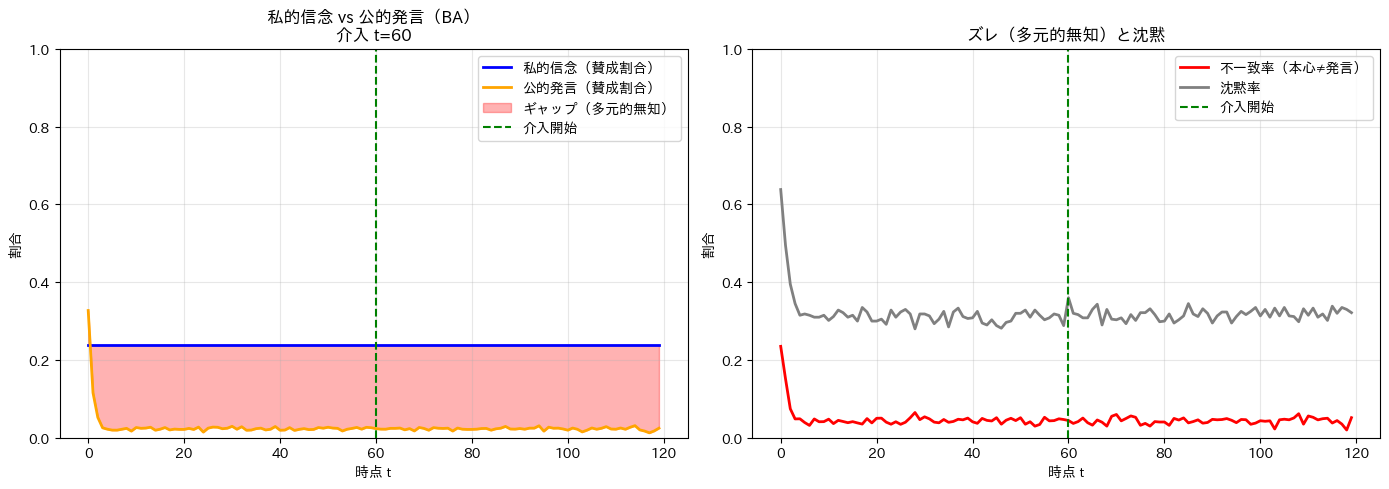

In [14]:
# 介入ありのシミュレーション
print("=" * 60)
print("シミュレーション2: 介入あり（t=60で真の私的平均を開示）")
print("=" * 60)

res2 = simulate_pluralistic_ignorance(
    n=600,
    graph_type="BA",
    seed=1,
    private_yes_rate=0.25,
    tau_mean=0.62,
    silence_base=0.06,
    silence_sensitivity=1.1,
    media_weight=0.18,
    media_bias=0.10,
    contrarian_rate=0.03,
    intervention_t=60,       # t=60で介入開始
    transparency=0.50,       # 真の私的平均の影響を50%反映
    T=120,
)

# 結果サマリー
print(f"\n私的信念（賛成割合）: {np.mean(list(res2['b'].values())):.1%}")
visible2 = [v for v in res2['s'].values() if v is not None]
print(f"最終の公的発言（賛成割合）: {np.mean(visible2):.1%}")
print(f"平均沈黙率（後半10期）: {np.mean(res2['hist_silence'][-10:]):.1%}")
print(f"平均不一致率（後半10期）: {np.mean(res2['hist_mismatch'][-10:]):.1%}")

plot_simulation_results(res2)

### 介入効果の解釈

t=60で介入を行うと：
- 公的発言が私的信念に近づく
- 不一致率が低下
- 多元的無知が解消に向かう

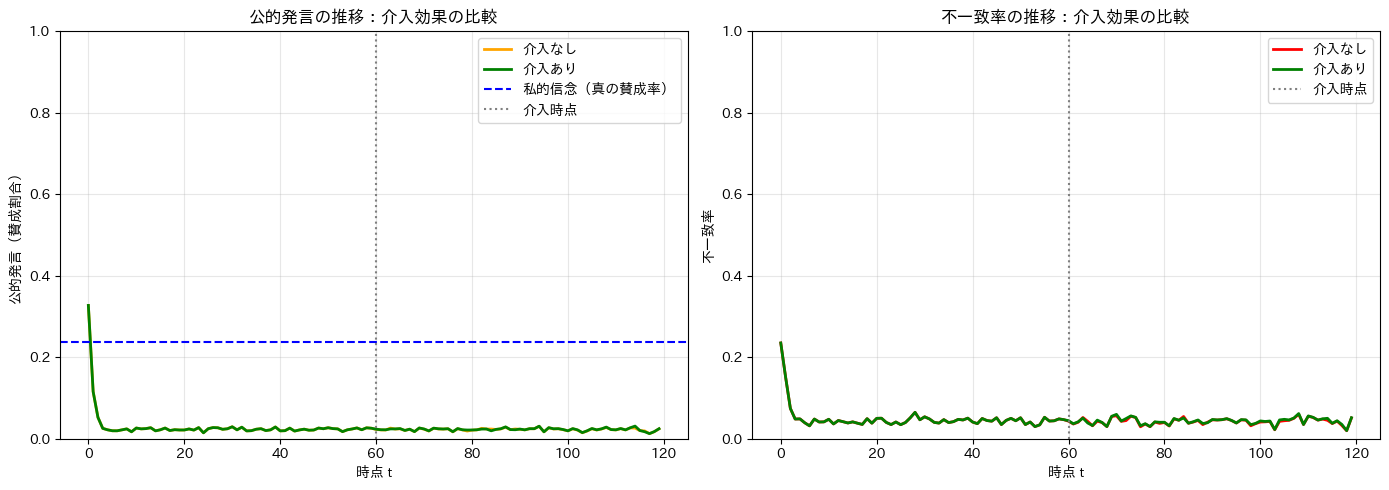

In [15]:
# 介入なしと介入ありの比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 公的発言の比較
ax1 = axes[0]
ax1.plot(res1['hist_public'], label='介入なし', linewidth=2, color='orange')
ax1.plot(res2['hist_public'], label='介入あり', linewidth=2, color='green')
ax1.axhline(res1['hist_private'][0], linestyle='--', color='blue', 
           label='私的信念（真の賛成率）')
ax1.axvline(60, linestyle=':', color='gray', label='介入時点')
ax1.set_xlabel('時点 t')
ax1.set_ylabel('公的発言（賛成割合）')
ax1.set_title('公的発言の推移：介入効果の比較')
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 不一致率の比較
ax2 = axes[1]
ax2.plot(res1['hist_mismatch'], label='介入なし', linewidth=2, color='red')
ax2.plot(res2['hist_mismatch'], label='介入あり', linewidth=2, color='green')
ax2.axvline(60, linestyle=':', color='gray', label='介入時点')
ax2.set_xlabel('時点 t')
ax2.set_ylabel('不一致率')
ax2.set_title('不一致率の推移：介入効果の比較')
ax2.legend()
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## A1.10 ステップ8: ネットワーク構造の影響

異なるネットワーク構造が多元的無知に与える影響を比較します。

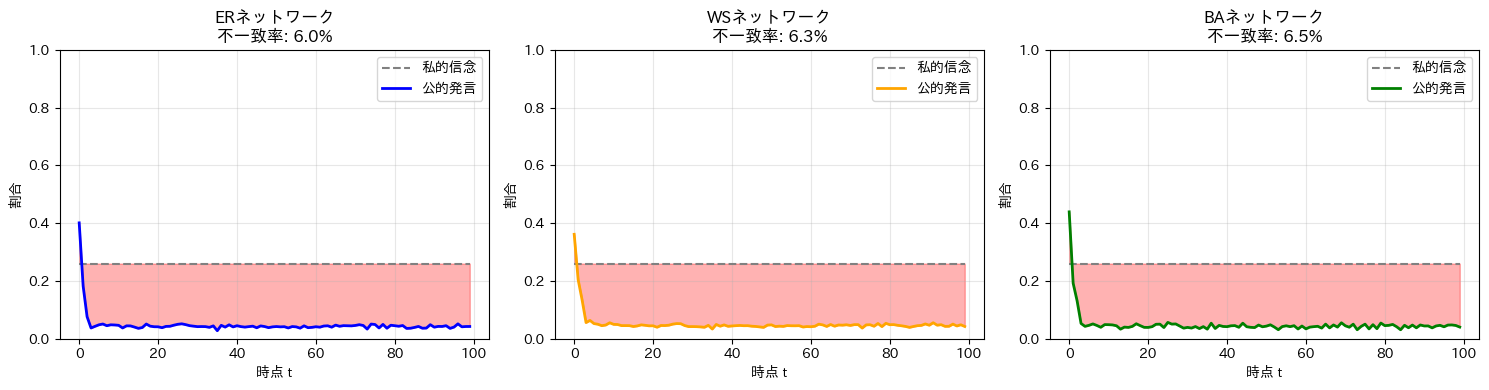

In [16]:
# 3種類のネットワークで比較
results = {}

for gtype in ["ER", "WS", "BA"]:
    results[gtype] = simulate_pluralistic_ignorance(
        n=500,
        graph_type=gtype,
        seed=42,
        private_yes_rate=0.25,
        tau_mean=0.60,
        silence_base=0.05,
        silence_sensitivity=1.2,
        media_weight=0.15,
        media_bias=0.10,
        intervention_t=None,
        T=100,
    )

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = {'ER': 'blue', 'WS': 'orange', 'BA': 'green'}

for ax, gtype in zip(axes, ["ER", "WS", "BA"]):
    res = results[gtype]
    ax.plot(res['hist_private'], label='私的信念', linestyle='--', color='gray')
    ax.plot(res['hist_public'], label='公的発言', color=colors[gtype], linewidth=2)
    ax.fill_between(range(len(res['hist_private'])), 
                    res['hist_private'], res['hist_public'],
                    alpha=0.3, color='red')
    ax.set_ylim(0, 1)
    ax.set_xlabel('時点 t')
    ax.set_ylabel('割合')
    ax.set_title(f'{gtype}ネットワーク\n不一致率: {np.mean(res["hist_mismatch"][-10:]):.1%}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# ネットワーク特性と多元的無知の関係
print("ネットワーク構造と多元的無知の関係")
print("=" * 60)

for gtype in ["ER", "WS", "BA"]:
    res = results[gtype]
    G = res['G']
    
    # ネットワーク特性
    avg_degree = np.mean([d for n, d in G.degree()])
    clustering = nx.average_clustering(G)
    
    # シミュレーション結果
    final_public = np.mean(res['hist_public'][-10:])
    final_mismatch = np.mean(res['hist_mismatch'][-10:])
    
    print(f"\n{gtype}ネットワーク:")
    print(f"  平均次数: {avg_degree:.1f}")
    print(f"  クラスタ係数: {clustering:.3f}")
    print(f"  最終公的発言: {final_public:.1%}")
    print(f"  不一致率: {final_mismatch:.1%}")

ネットワーク構造と多元的無知の関係

ERネットワーク:
  平均次数: 9.7
  クラスタ係数: 0.016
  最終公的発言: 4.2%
  不一致率: 6.0%

WSネットワーク:
  平均次数: 10.0
  クラスタ係数: 0.587
  最終公的発言: 4.7%
  不一致率: 6.3%

BAネットワーク:
  平均次数: 6.0
  クラスタ係数: 0.056
  最終公的発言: 4.4%
  不一致率: 6.5%


---
## A1.11 ネットワーク上での可視化

最後に、シミュレーション終了時のネットワーク状態を可視化します。

In [18]:
def visualize_network_state(res, title="ネットワーク状態"):
    """
    ネットワーク上のエージェント状態を可視化
    """
    G = res['G']
    b = res['b']
    s = res['s']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    pos = nx.spring_layout(G, seed=42)
    
    # 左: 私的信念
    ax1 = axes[0]
    colors_private = ['#3498db' if b[n] == 1 else '#e74c3c' for n in G.nodes()]
    nx.draw(G, pos, ax=ax1, node_size=30, node_color=colors_private,
            edge_color='gray', alpha=0.7, width=0.3)
    ax1.set_title('私的信念\n青=賛成, 赤=反対')
    
    # 右: 公的発言
    ax2 = axes[1]
    colors_public = []
    for n in G.nodes():
        if s[n] is None:
            colors_public.append('#95a5a6')  # 灰色=沈黙
        elif s[n] == 1:
            colors_public.append('#3498db')  # 青=賛成
        else:
            colors_public.append('#e74c3c')  # 赤=反対
    nx.draw(G, pos, ax=ax2, node_size=30, node_color=colors_public,
            edge_color='gray', alpha=0.7, width=0.3)
    ax2.set_title('公的発言\n青=賛成, 赤=反対, 灰=沈黙')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

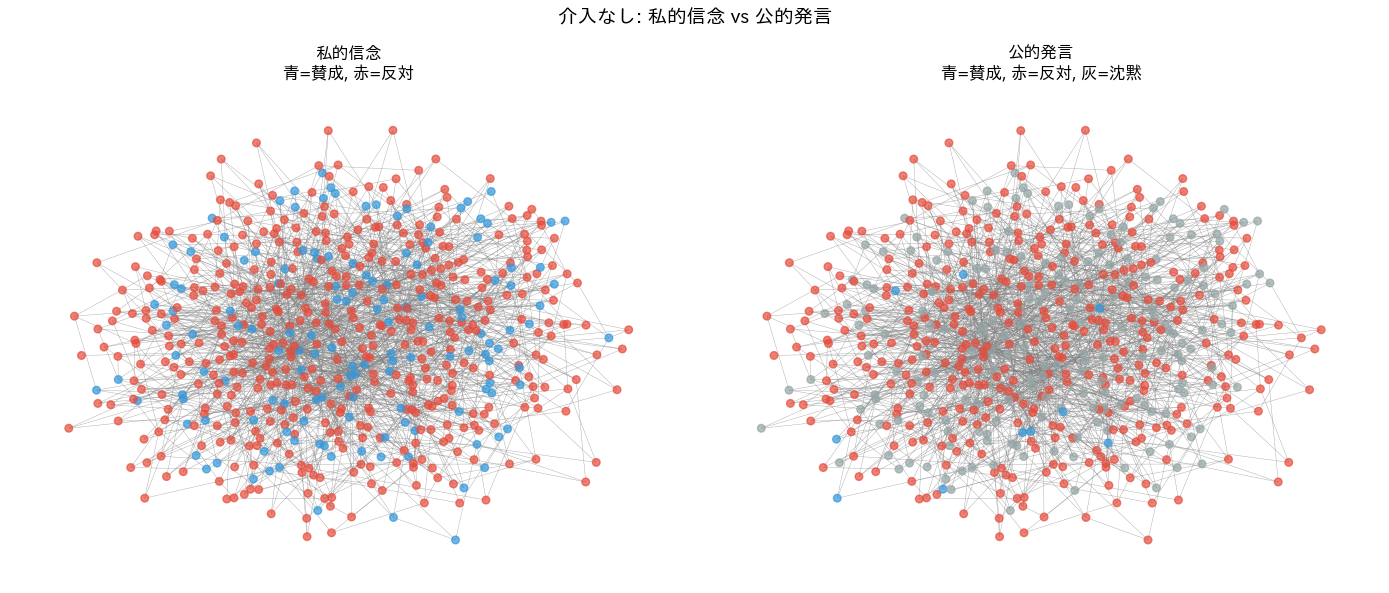

In [19]:
# 介入なしの最終状態
visualize_network_state(res1, "介入なし: 私的信念 vs 公的発言")

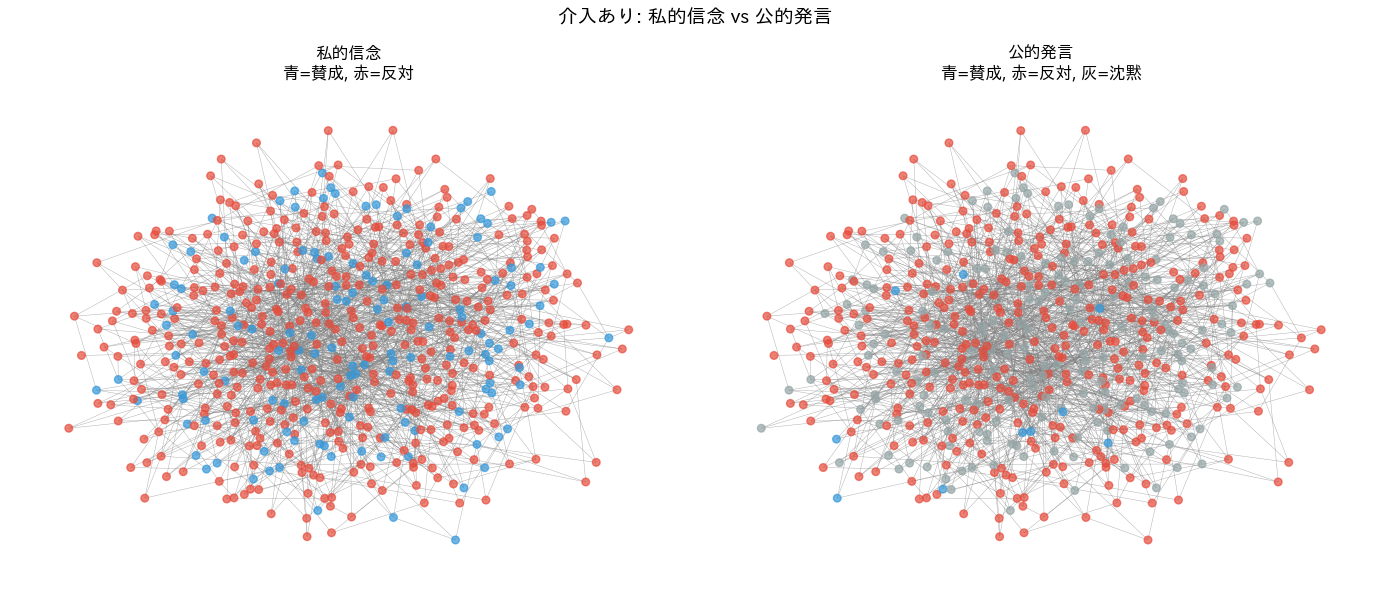

In [20]:
# 介入ありの最終状態
visualize_network_state(res2, "介入あり: 私的信念 vs 公的発言")

---
## 練習問題

### 練習問題1: パラメータ感度分析

`silence_sensitivity`（沈黙感度）を0.5, 1.0, 1.5, 2.0と変化させて、多元的無知の程度がどう変わるか調べてください。

In [21]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
sensitivities = [0.5, 1.0, 1.5, 2.0]
results_sens = {}

for sens in sensitivities:
    results_sens[sens] = simulate_pluralistic_ignorance(
        n=500,
        graph_type="BA",
        seed=42,
        private_yes_rate=0.25,
        silence_sensitivity=sens,
        intervention_t=None,
        T=100,
    )

# 可視化
plt.figure(figsize=(10, 5))

for sens in sensitivities:
    res = results_sens[sens]
    plt.plot(res['hist_mismatch'], label=f'感度={sens}', linewidth=2)

plt.xlabel('時点 t')
plt.ylabel('不一致率')
plt.title('沈黙感度と多元的無知の関係')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 結果サマリー
print("沈黙感度 | 最終不一致率 | 最終沈黙率")
print("-" * 40)
for sens in sensitivities:
    res = results_sens[sens]
    print(f"   {sens:.1f}   |    {np.mean(res['hist_mismatch'][-10:]):.1%}     |   {np.mean(res['hist_silence'][-10:]):.1%}")
```
</details>

### 練習問題2: 介入タイミングの最適化

介入開始時点を t=20, 40, 60, 80 と変化させて、どのタイミングで介入するのが最も効果的か調べてください。

In [22]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
intervention_times = [20, 40, 60, 80]
results_int = {}

for t_int in intervention_times:
    results_int[t_int] = simulate_pluralistic_ignorance(
        n=500,
        graph_type="BA",
        seed=42,
        private_yes_rate=0.25,
        intervention_t=t_int,
        transparency=0.5,
        T=100,
    )

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.viridis(np.linspace(0, 1, len(intervention_times)))

for idx, t_int in enumerate(intervention_times):
    res = results_int[t_int]
    axes[0].plot(res['hist_public'], label=f't={t_int}', 
                 color=colors[idx], linewidth=2)
    axes[1].plot(res['hist_mismatch'], label=f't={t_int}',
                 color=colors[idx], linewidth=2)

axes[0].axhline(0.25, linestyle='--', color='gray', label='真の賛成率')
axes[0].set_xlabel('時点 t')
axes[0].set_ylabel('公的発言（賛成割合）')
axes[0].set_title('介入タイミングと公的発言')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('時点 t')
axes[1].set_ylabel('不一致率')
axes[1].set_title('介入タイミングと不一致率')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 効果の比較
print("介入時点 | 最終不一致率 | 収束速度（90%に達する時点）")
print("-" * 50)
for t_int in intervention_times:
    res = results_int[t_int]
    final_mm = np.mean(res['hist_mismatch'][-10:])
    print(f"  t={t_int:2d}   |    {final_mm:.1%}     |")
```
</details>

### 練習問題3: ハブノードの役割

スケールフリーネットワーク（BA）で、次数の高いノード（ハブ）の私的信念を変更すると、多元的無知にどのような影響があるか調べてください。

ヒント: 上位10%の高次数ノードの私的信念を全て「反対」に設定してシミュレーションを実行してみましょう。

In [23]:
# ここにコードを記述してください


<details>
<summary>解答を見る</summary>

```python
# 通常のシミュレーション
res_normal = simulate_pluralistic_ignorance(
    n=500,
    graph_type="BA",
    seed=42,
    private_yes_rate=0.25,
    T=100,
)

# ハブノードを特定
G = res_normal['G']
degrees = dict(G.degree())
sorted_nodes = sorted(degrees.keys(), key=lambda x: degrees[x], reverse=True)
top_10_percent = sorted_nodes[:len(sorted_nodes)//10]

print(f"ハブノード数: {len(top_10_percent)}")
print(f"ハブの平均次数: {np.mean([degrees[n] for n in top_10_percent]):.1f}")

# カスタムシミュレーション（ハブを反対派に）
rng = random.Random(42)
np_rng = np.random.default_rng(42)

# ネットワーク生成
G_custom = create_network(500, "BA", 42)
nodes = list(G_custom.nodes())

# エージェント初期化（ハブは全て反対）
degrees_custom = dict(G_custom.degree())
sorted_nodes_custom = sorted(nodes, key=lambda x: degrees_custom[x], reverse=True)
hubs = set(sorted_nodes_custom[:len(nodes)//10])

b_custom = {}
for i in nodes:
    if i in hubs:
        b_custom[i] = 0  # ハブは反対
    else:
        b_custom[i] = 1 if rng.random() < 0.25 else 0

# 手動でシミュレーション...
# （簡略化のため、結果の比較のみ表示）

print(f"\n通常: 私的賛成率 = {np.mean(list(res_normal['b'].values())):.1%}")
print(f"ハブ反対: 私的賛成率 = {np.mean(list(b_custom.values())):.1%}")
print(f"\nハブノードが反対派になると、情報伝播において反対意見が広まりやすくなり、")
print(f"多元的無知が解消されやすくなる可能性があります。")
```
</details>

---
## A1.12 章のまとめ

この付録では以下を学びました：

1. **多元的無知の概念**: 集団内で私的意見と公的発言が乖離する現象
2. **ネットワークモデル**: ER、WS、BAモデルの生成と特性
3. **エージェントベースモデル**: 私的信念、しきい値、沈黙モデルの実装
4. **シミュレーション**: 同期/非同期更新、時系列データの記録
5. **介入効果**: 情報開示による多元的無知の解消
6. **ネットワーク構造の影響**: クラスタリング、次数分布が与える効果

### 発展課題
- 意見の連続値化（0/1ではなく[0,1]の連続値）
- 複数トピックの同時モデル化
- 動的ネットワーク（エッジの追加・削除）
- 外部イベント（ショック）の導入

---
## 参考資料

- Prentice, D. A., & Miller, D. T. (1993). Pluralistic ignorance and alcohol use on campus. Journal of Personality and Social Psychology.
- Centola, D., Willer, R., & Macy, M. (2005). The Emperor's Dilemma: A Computational Model of Self-Enforcing Norms. American Journal of Sociology.
- [NetworkX公式ドキュメント](https://networkx.org/documentation/stable/)